# Population structure and diversity

## Setup

In [3]:
# Load required packages
library(tidyverse)
library(wesanderson)
library(vegan)
library(umap)

── Attaching packages ───────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ──────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



In [4]:
# Path to results for this project
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'

In [5]:
# Sample order from ANGSD
angsd_sample_order_path <- paste0(results_prefix, 'program_resources/angsd_allFinalSamples_4fold_order.txt')
sample_order <- suppressMessages(
        read_delim(angsd_sample_order_path, col_names = FALSE, delim = '\t')
)

In [6]:
# Load sample sheet
ss_inpath <- '../resources/sequencedPlants_phenotypesHabitat.txt'
samples <- suppressMessages(
        read_delim(ss_inpath, col_names = TRUE, delim = '\t') %>%
        filter(Sample %in% sample_order$X1)
)

### Functions

In [7]:
# Function to calculate % variance and cummulative variance from PC
# Used to generate summary table rather than printing the lengthy `princomp()` summary
pca_importance <- function(x) {
  vars <- x$sdev^2
  vars <- vars/sum(vars)
  rbind(`Standard deviation` = x$sdev, `Proportion of Variance` = vars, 
      `Cumulative Proportion` = cumsum(vars))
}

# Function to load NGSadmix log files
load_ngsadmix_log <- function(path){
    seed <- as.numeric(str_extract(basename(path), pattern = '(?<=seed)[0-9]+(?=\\.log)'))
    
    logfile <- readLines(path)[9]  ## 9 index is for line with likelihood
    like <- as.numeric(str_extract(logfile, pattern = '(?<=like=)-[0-9]+\\.[0-9]+'))
    
    df_out <- data.frame(seed = seed, like = like)
    return(df_out)
}

# Function to load thetas for a given habitat
load_pi <- function(habitat){
    path <- paste0(results_prefix, sprintf('angsd/summary_stats/thetas/byHabitat/4fold_%s.thetas.idx.pestPG', habitat))
    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               habitat = habitat)
    return(df)
}

# Function to load Fst for habitat comparisons
load_fst <- function(habitat_combination){
    path <- paste0(results_prefix, sprintf('angsd/summary_stats/hudson_fst/byHabitat/4fold_%s_readable.fst', habitat_combination))
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(read_delim(path, delim = '\t', col_names = colnames)) %>%
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        group_by(chrom) %>%
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(hab_comb = habitat_combination)
    return(df)
}

# Function to load chromosomal NGSrelate results
load_relatedness <- function(path){
    chrom <- str_extract(basename(path), '^(.+)(?=_4fold)')
    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        mutate(chrom = chrom) %>%
        dplyr::select(-starts_with('J')) %>%
        dplyr::select(chrom, everything())
    return(df)
}

## Population structure

All population structure analyses were performed using 199,624 4fold SNPs from across the genome. SNPs had MAF > 0.05 and were pruned for LD such that no pairwise $r^2$ was greater than 0.2

### Pricipal Components Analysis (PCA)

- Results from a PCA performed in `pcangsd` using genotype likelihoods estimated across all samples in `ANGSD`

In [8]:
# Load covariance matrix
covMat_path <- paste0(results_prefix, 'population_structure/pcangsd/allSamples_allChroms_4fold_maf0.05_pcangsd.cov')
covMat <- suppressMessages(
        read_delim(covMat_path, col_names = FALSE, delim = ' ')
)

In [9]:
# Perform eigen decomposition of covariance matrix
# Extract eigenvectors and bind with sample sheet for plotting and coloring by habitat
eigenvectors <- eigen(covMat)
eigen_df <- eigenvectors$vectors %>%
        as.data.frame() %>%
        dplyr::select(V1, V2, V3, V4) %>%
        rename('PC1' = 'V1',
               'PC2' = 'V2',
               'PC3' = 'V3',
               'PC4' = 'V4') %>%
    bind_cols(., samples)

In [10]:
# Percent Variance explained by first 4 PCs
pca_importance(summary(princomp(covMat))) %>% 
    as.data.frame() %>% 
    rownames_to_column('var') %>% 
    dplyr::select(var, Comp.1:Comp.4)

var,Comp.1,Comp.2,Comp.3,Comp.4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Standard deviation,0.17305297,0.13123385,0.12829328,0.11584970
Proportion of Variance,0.03453693,0.01986174,0.01898162,0.01547802
Cumulative Proportion,0.03453693,0.05439866,0.07338029,0.08885831


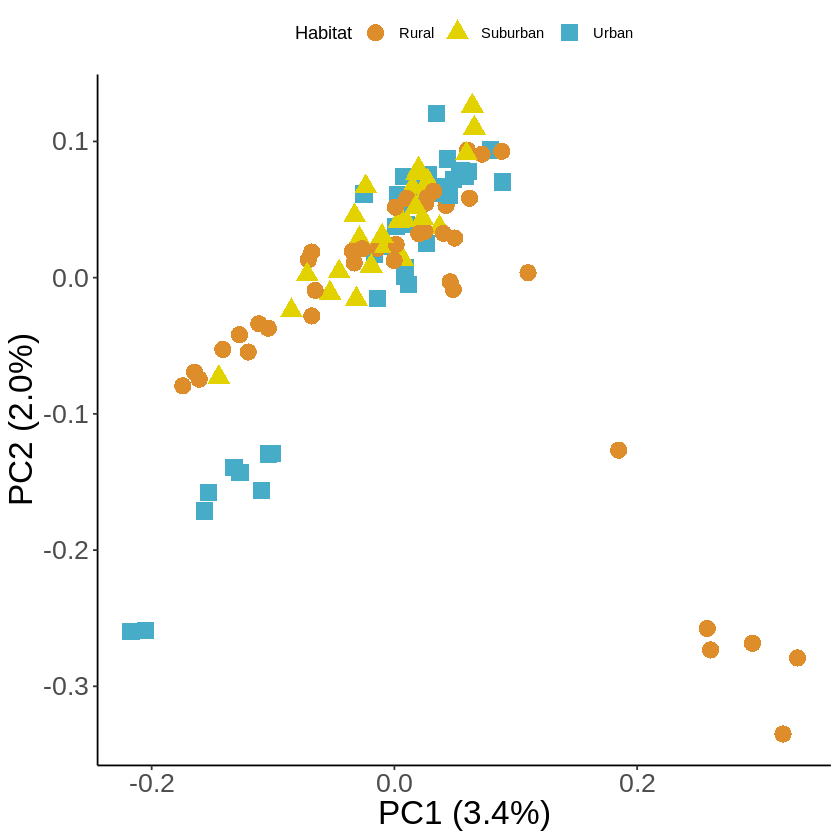

In [12]:
cols_hab <- wes_palette("FantasticFox1", n = 3, type = 'discrete')
pca_plot <- eigen_df %>%
    ggplot(., aes(x = PC1, y = PC2, color = Habitat, shape = Habitat)) +
        geom_point(size = 4.5) +
        scale_color_manual(values = cols_hab) +
        theme_classic() +
        xlab('PC1 (3.4%)') + ylab('PC2 (2.0%)') +
#         scale_x_continuous(breaks = seq(-0.10, 0.10, 0.10)) +
        theme(axis.text = element_text(size = 16),
              axis.title = element_text(size = 20),
              legend.position = 'top')
pca_plot

In [13]:
figures_path <- '/scratch/projects/trifolium/gwsd/figures/'
dir.create(figures_path, showWarnings = FALSE)
ggsave(filename = paste0(figures_path, 'pca.pdf'), plot = pca_plot, device = 'pdf', 
       width = 8, height = 8, units = 'in', dpi = 600, )

In [14]:
# What are those outlier cluster?
eigen_df %>% filter((PC1 > 0.1 & PC2 < -0.1) | (PC1 < 0 & PC2 < -0.15))

PC1,PC2,PC3,PC4,Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.2052079,-0.2590398,-0.34449763,-0.044257195,s_40_6,Urban,40,6,0,NA,0
-0.1092062,-0.1560143,-0.23554044,-0.113726377,s_40_7,Urban,40,7,0,NA,0
-0.1532197,-0.1578148,-0.24652380,-0.132821508,s_40_10,Urban,40,10,0,NA,0
-0.2171102,-0.2598931,-0.25536254,0.047818681,s_40_17,Urban,40,17,0,NA,1
-0.1566943,-0.1713343,-0.19321991,-0.079199482,s_40_19,Urban,40,19,0,NA,0
0.1847984,-0.1266080,0.01447376,-0.122007494,s_7_4,Rural,7,4,1,1,NA
0.2950361,-0.2685175,0.05752705,0.043332572,s_7_6,Rural,7,6,1,1,NA
0.2605849,-0.2733267,0.07037410,-0.031164991,s_7_7,Rural,7,7,1,1,NA
0.3321644,-0.2792067,0.06331880,0.001404353,s_7_13,Rural,7,13,1,1,NA


### Uniform Manifold Approximation Projection (UMAP)

- UMAP for same set of samples
- Uses number of UMAP components equal to the number of significant PCs from the PCA aboe, assessed using the broken stick model
- Takes as input a distance matrix derived from the covariance matrix of sample allele frequencies

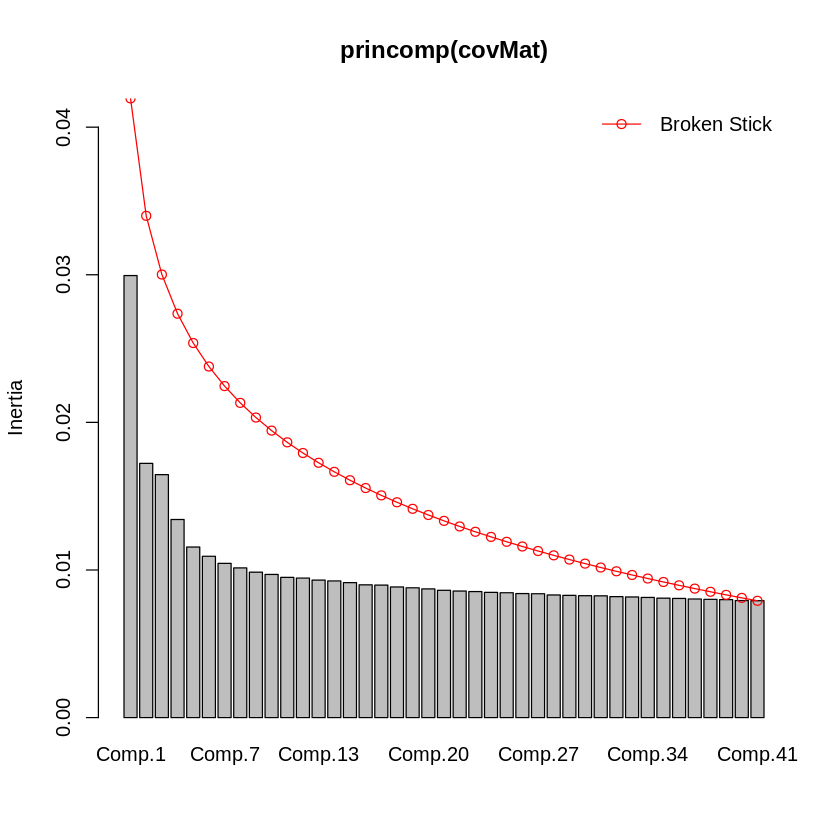

In [15]:
screeplot(princomp(covMat), bstick = TRUE, npcs = 41)

In [19]:
distMat <- as.matrix(dist(covMat))
gwsd_umap <- umap(distMat, random_state = 42, input="dist", n_neighbors = 15, min_dist = 0.1, n_components = 41)
gwsd_umap_layout <- gwsd_umap$layout %>% 
    as_tibble() %>% 
    bind_cols(., samples)

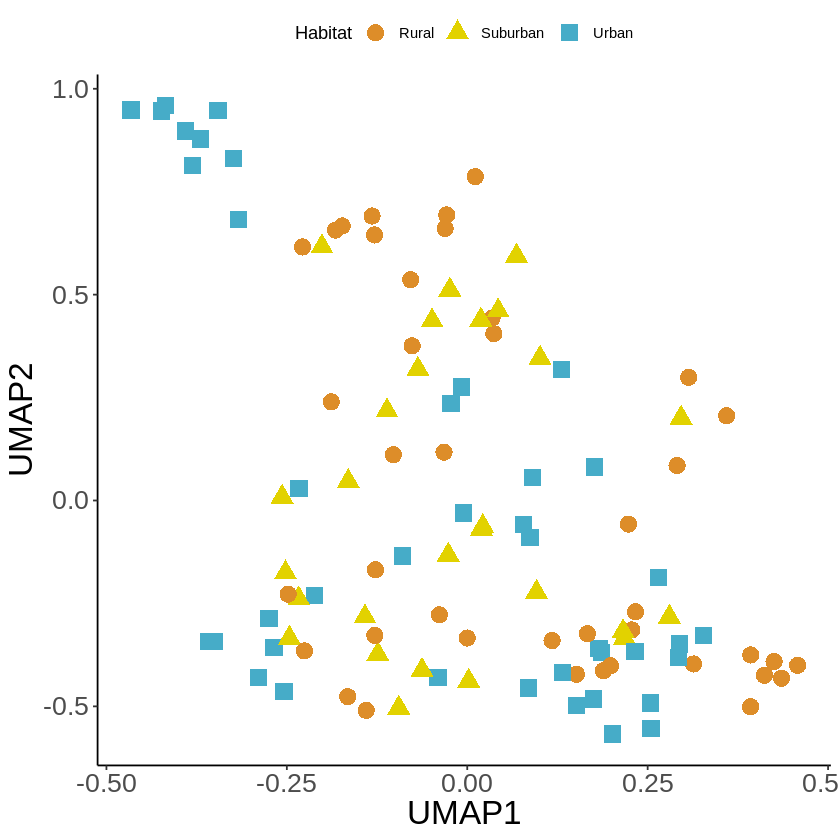

In [20]:
umap_plot <- gwsd_umap_layout %>%
    ggplot(., aes(x = V1, y = V2, color = Habitat, shape = Habitat)) +
        geom_point(size = 4.5, alpha = 1) +
        scale_color_manual(values = cols_hab) +
        theme_classic() +
        xlab('UMAP1') + ylab('UMAP2') +
        theme(axis.text = element_text(size = 16),
              axis.title = element_text(size = 20),
              legend.position = 'top')
umap_plot

In [21]:
ggsave(filename = paste0(figures_path, 'umap.pdf'), plot = umap_plot, device = 'pdf', 
       width = 8, height = 8, units = 'in', dpi = 600, )

In [22]:
# What are those outlier cluster?
gwsd_umap_layout %>% filter((V1 > 0.3 & V2 < -0.4) | ( V1 < 0.25 & V2 > 0.5))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V39,V40,V41,Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.36995028,0.8778698,0.388424976,0.4758312,-0.42674515,0.042552659,0.3025904,0.37585284,-0.320960977,0.4886174,⋯,0.09907610,0.06678804,-0.4158778,s_40_1,Urban,40,1,0,NA,0
-0.34527632,0.9463306,0.439506947,0.4854384,-0.41791039,0.020900872,0.3010252,0.37609510,-0.352148356,0.5020397,⋯,0.16267938,0.05883471,-0.4242081,s_40_3,Urban,40,3,0,NA,0
-0.41765972,0.9584279,0.460523927,0.5494947,-0.48963179,0.064178650,0.2893502,0.44881966,-0.346473919,0.5379431,⋯,0.12685560,0.05863937,-0.4237857,s_40_6,Urban,40,6,0,NA,0
-0.42322078,0.9460614,0.455167376,0.5105153,-0.46751104,0.080110402,0.2695977,0.44111822,-0.343692551,0.5234844,⋯,0.08621285,0.02822978,-0.4207884,s_40_7,Urban,40,7,0,NA,0
-0.31720893,0.6832965,0.312878491,0.4592497,-0.41659962,0.041580800,0.2711708,0.32541409,-0.251748526,0.4210524,⋯,0.09944935,0.08165884,-0.3410715,s_40_8,Urban,40,8,0,NA,1
-0.39059119,0.8975378,0.406791898,0.5973381,-0.56090340,0.059678976,0.2898495,0.44696887,-0.310798091,0.5290871,⋯,0.12168624,0.05688391,-0.3846664,s_40_10,Urban,40,10,0,NA,0
-0.32361123,0.8310704,0.362120605,0.5522875,-0.51029817,0.009738259,0.3223230,0.36788250,-0.292607777,0.4856096,⋯,0.16137787,0.10398772,-0.3625997,s_40_12,Urban,40,12,1,NA,1
-0.38066162,0.8145269,0.367670746,0.5453113,-0.52402596,0.083887799,0.2540236,0.42000218,-0.283425937,0.4830465,⋯,0.06741267,0.03900092,-0.3463953,s_40_17,Urban,40,17,0,NA,1
-0.46607293,0.9485223,0.428498007,0.6071137,-0.58084880,0.055987707,0.3555821,0.48177609,-0.334069580,0.5861357,⋯,0.09214271,0.09146536,-0.4645377,s_40_19,Urban,40,19,0,NA,0


### Admixture

- I estimated admixture proportions using `NGSadmix` with genotype likelihoods across all samples estimated in `ANGSD`
    - I ran all K values from 2 to 10 10 times, each with a different random seed
    - Uses same 4fold SNPs as above
- I used Evanno's delta-K method implemented in `CLUMPAK` to estimate the upper-most level of structure (i.e., "optimal" K)

In [23]:
# Best K by Evanno is 4. Load logs for K = 4
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K

[1] "Thu May 25 03:15:40 2023: Optimal K by Evanno is: 5"

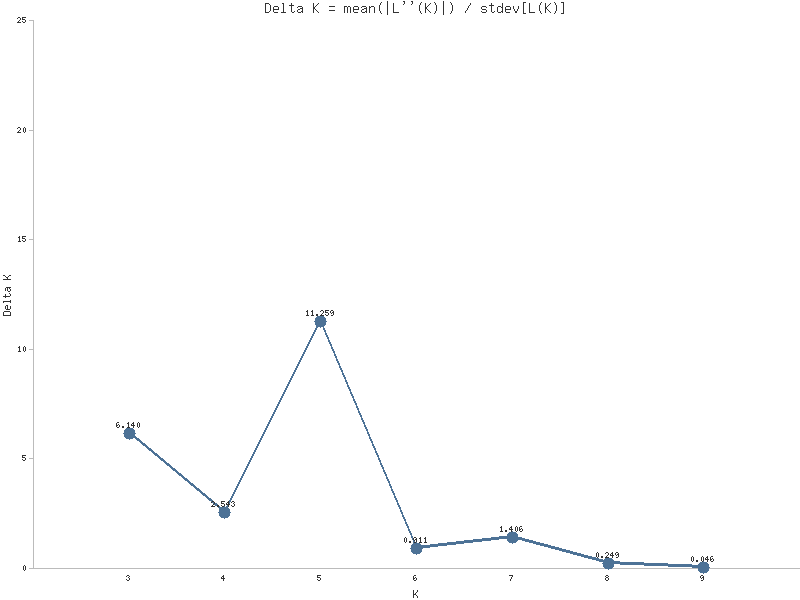

In [24]:
# Peak in Delta K looks good
library("IRdisplay")
display_png(file="/scratch/projects/trifolium/gwsd/results/population_structure/bestKbyEvanno/Best_K_By_Evanno-DeltaKByKGraph.png") 

#### K = 5 (Best K)

In [25]:
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/K5/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

In [26]:
like_df

seed,like
<dbl>,<dbl>
1,-14253537
10,-14251574
2,-14252772
3,-14252517
4,-14252776
5,-14250572
6,-14251420
7,-14251152
8,-14251800


In [27]:
# Get lowest likelihood for plotting
like_df %>%
    filter(like == min(like))

seed,like
<dbl>,<dbl>
1,-14253537


In [28]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/K5/ngsadmix_4fold_maf0.05_K5_seed1.qopt')
admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X6) %>%
    bind_cols(., samples) %>% 
    pivot_longer(X1:X5, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
head(admix)

Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac,name,Probs
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
s_40_1,Urban,40,1,0,NA,0,X1,1
s_40_1,Urban,40,1,0,NA,0,X2,0
s_40_1,Urban,40,1,0,NA,0,X3,0
s_40_1,Urban,40,1,0,NA,0,X4,0
s_40_1,Urban,40,1,0,NA,0,X5,0
s_40_3,Urban,40,3,0,NA,0,X1,1


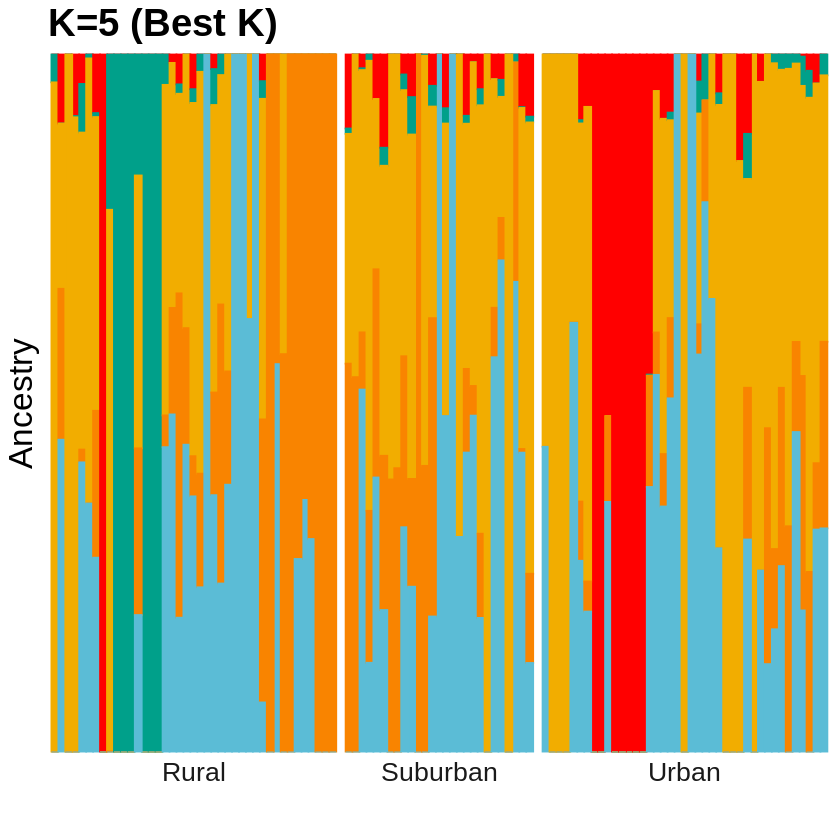

In [30]:
cols_admix <- wes_palette("Darjeeling1", n = 5, type = 'continuous')
admix_plot_K5 <- 
  ggplot(admix, aes(factor(Sample), Probs, fill = factor(name), color = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_relevel(Habitat,'Rural', 'Suburban', 'Urban'), switch = "x", scales = "free", space = "free") +
  theme_minimal() + labs(x = "", title = "K=5 (Best K)", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  scale_fill_manual(values = cols_admix) + 
  scale_color_manual(values = cols_admix) +
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.1, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=16),
    axis.title = element_text(size=20),
    strip.text.x = element_text(size = 16),
    plot.title = element_text(size = 23, face = 'bold'),
    axis.text.y = element_blank()
  ) 
admix_plot_K5

In [32]:
ggsave(filename = paste0(figures_path, 'admix_K5.pdf'), plot = admix_plot_K5, device = 'pdf', 
       width = 20, height = 3, units = 'in', dpi = 600)

#### K = 4

In [33]:
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/K4/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)
# Get lowest likelihood for plotting
like_df %>%
    filter(like == min(like))

seed,like
<dbl>,<dbl>
2,-14389790


In [42]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/K4/ngsadmix_4fold_maf0.05_K4_seed2.qopt')
admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X5) %>%
    bind_cols(., samples) %>% 
    pivot_longer(X1:X4, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
head(admix)

Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac,name,Probs
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
s_40_1,Urban,40,1,0,NA,0,X1,0.37848
s_40_1,Urban,40,1,0,NA,0,X2,0.59793
s_40_1,Urban,40,1,0,NA,0,X3,0.00000
s_40_1,Urban,40,1,0,NA,0,X4,0.02358
s_40_3,Urban,40,3,0,NA,0,X1,0.00000
s_40_3,Urban,40,3,0,NA,0,X2,0.67488


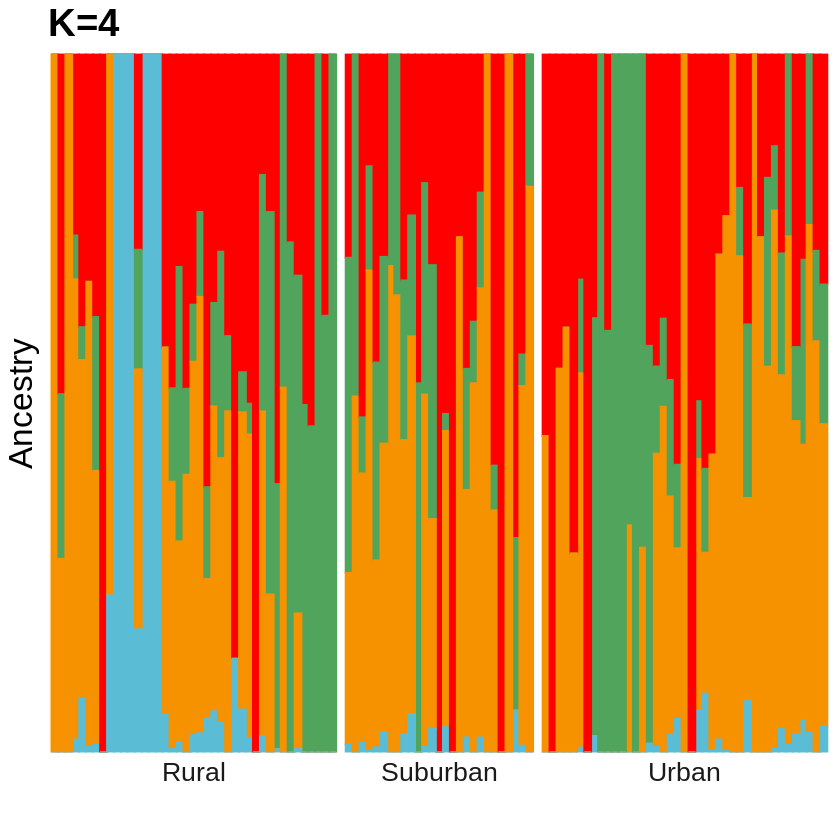

In [43]:
cols_admix <- wes_palette("Darjeeling1", n = 4, type = 'continuous')
admix_plot_K4 <- 
  ggplot(admix, aes(factor(Sample), Probs, fill = factor(name), color = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_relevel(Habitat,'Rural', 'Suburban', 'Urban'), switch = "x", scales = "free", space = "free") +
  theme_minimal() + labs(x = "", title = "K=4", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  scale_fill_manual(values = cols_admix) + 
  scale_color_manual(values = cols_admix) +
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.1, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=16),
    axis.title = element_text(size=20),
    strip.text.x = element_text(size = 16),
    plot.title = element_text(size = 23, face = 'bold'),
    axis.text.y = element_blank()
  ) 
admix_plot_K4

In [44]:
ggsave(filename = paste0(figures_path, 'admix_K4.pdf'), plot = admix_plot_K4, device = 'pdf', 
       width = 20, height = 3, units = 'in', dpi = 600, )

#### K = 6

In [47]:
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/K6/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)
# Get lowest likelihood for plotting
like_df %>%
    filter(like == min(like))

seed,like
<dbl>,<dbl>
2,-14144421


In [48]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/K6/ngsadmix_4fold_maf0.05_K6_seed8.qopt')
admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X7) %>%
    bind_cols(., samples) %>% 
    pivot_longer(X1:X6, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
head(admix)

Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac,name,Probs
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
s_40_1,Urban,40,1,0,NA,0,X1,0.14795
s_40_1,Urban,40,1,0,NA,0,X2,0.00000
s_40_1,Urban,40,1,0,NA,0,X3,0.00000
s_40_1,Urban,40,1,0,NA,0,X4,0.49959
s_40_1,Urban,40,1,0,NA,0,X5,0.35246
s_40_1,Urban,40,1,0,NA,0,X6,0.00000


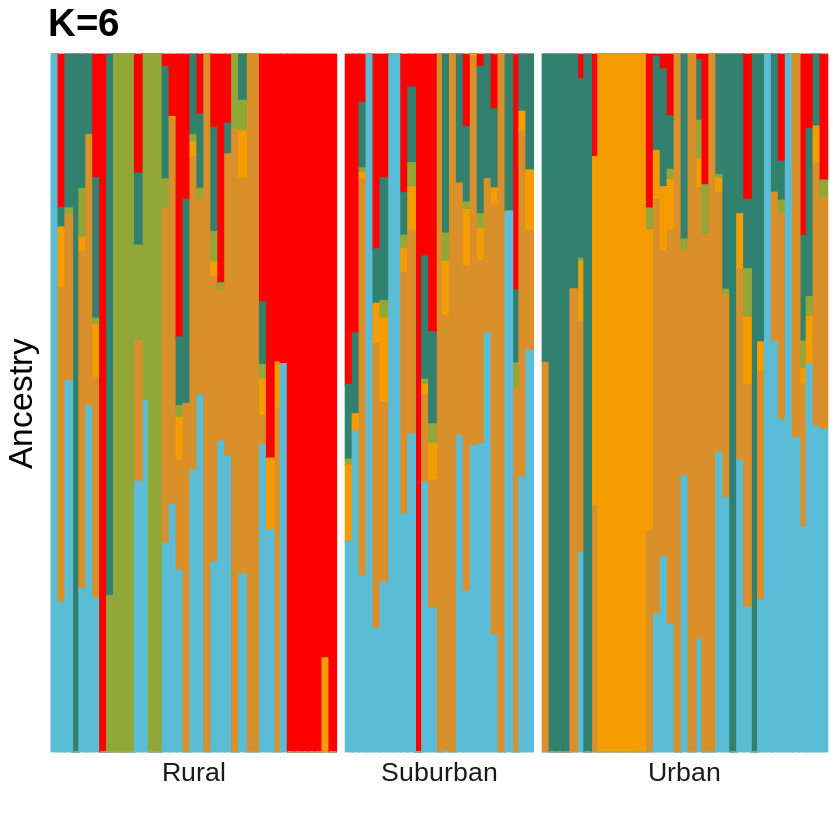

In [49]:
cols_admix <- wes_palette("Darjeeling1", n = 6, type = 'continuous')
admix_plot_K6 <- 
  ggplot(admix, aes(factor(Sample), Probs, fill = factor(name), color = factor(name))) +
  geom_col(width=1) +
  facet_grid(~fct_relevel(Habitat,'Rural', 'Suburban', 'Urban'), switch = "x", scales = "free", space = "free") +
  theme_minimal() + labs(x = "", title = "K=6", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  scale_fill_manual(values = cols_admix) + 
  scale_color_manual(values = cols_admix) +
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.1, "lines"),
    axis.text.x = element_blank(),
    panel.grid = element_blank(),
    axis.text = element_text(size=16),
    axis.title = element_text(size=20),
    strip.text.x = element_text(size = 16),
    plot.title = element_text(size = 23, face = 'bold'),
    axis.text.y = element_blank()
  ) 
admix_plot_K6

In [50]:
ggsave(filename = paste0(figures_path, 'admix_K6.pdf'), plot = admix_plot_K6, device = 'pdf', 
       width = 20, height = 3, units = 'in', dpi = 600, )

### Pi and Fst

- Pi and Fst were estimated in `ANGSD` using approximately 9.7 million 4fold sites across the genome

#### By Habitat

- Pi in each of 3 habitats
- Pairwise Fst across all 3 habitat types
- TODO: Consider ammending this to estimate all 3 pairwise comparison at once so that `ANGSD` also estimates the population branch statistic

In [51]:
# Load in thetas for all habitats and merge into single dataframe
pi_stats <- purrr::map_dfr(c('Urban', 'Suburban', 'Rural'), load_pi)

In [52]:
pi_stats %>% 
    group_by(habitat) %>% 
    summarize(mean(tp_scaled))

habitat,mean(tp_scaled)
<chr>,<dbl>
Rural,0.01875606
Suburban,0.01879879
Urban,0.01877678


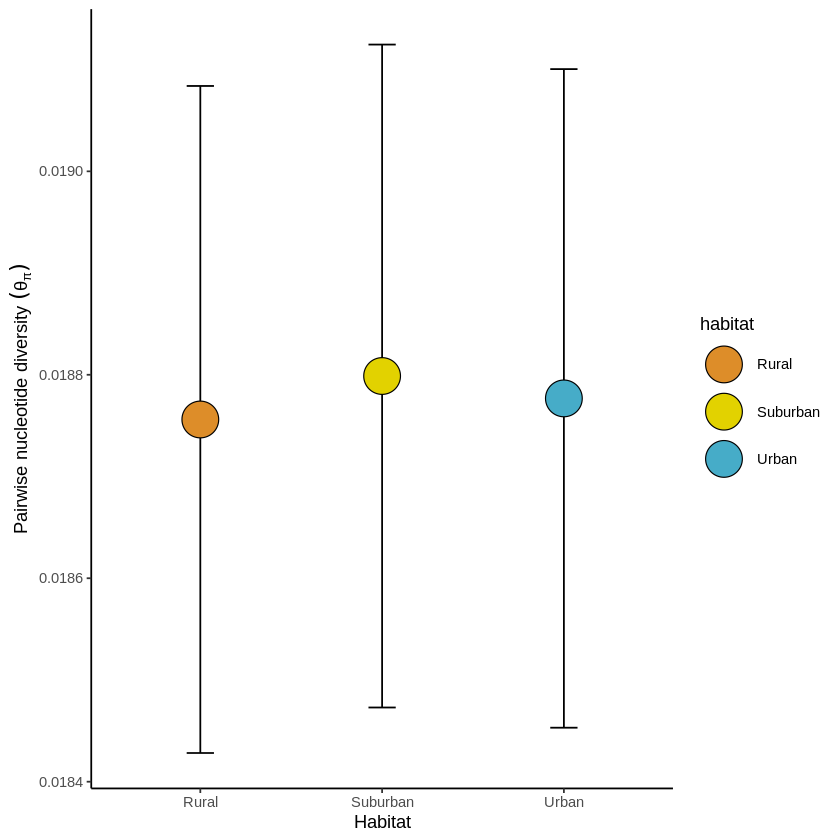

In [54]:
pi_stats %>%
    group_by(habitat) %>%
    summarise(mean_tp = mean(tp_scaled),
              sd_tp = sd(tp_scaled),
              se_tp = sd_tp / sqrt(n())) %>%
    ggplot(., aes(x = habitat, y = mean_tp)) +
        geom_errorbar(aes(ymin = mean_tp - se_tp, ymax = mean_tp + se_tp), width = 0.15) +
        geom_point(size = 10, shape = 21, aes(fill = habitat)) +
        xlab('Habitat') + ylab(expression(Pairwise~nucleotide~diversity~('\u03B8'['\u03C0']))) +
        scale_fill_manual(values = cols_hab) +
#         coord_cartesian(ylim = c(0.02215, 0.02280)) +
        theme_classic()

In [55]:
# Load in fst for all habitat comparisons and merge into single dataframe
fst_stats <- purrr::map_dfr(c('Rural_Suburban', 'Urban_Rural', 'Urban_Suburban'), load_fst)

In [56]:
fst_stats

chrom,num_sum,denom_sum,fst,nSites,hab_comb
<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
Chr01_Occ,91.50563,14722.047,0.006215551,799953,Rural_Suburban
Chr01_Pall,81.91693,13814.860,0.005929624,789664,Rural_Suburban
Chr02_Occ,53.68691,9140.997,0.005873200,453414,Rural_Suburban
Chr02_Pall,48.21671,8156.634,0.005911349,448643,Rural_Suburban
Chr03_Occ,96.00967,15124.689,0.006347877,753594,Rural_Suburban
Chr03_Pall,84.82880,13752.866,0.006168082,737439,Rural_Suburban
Chr04_Occ,120.14581,15291.044,0.007857266,746466,Rural_Suburban
Chr04_Pall,85.08602,13912.008,0.006116012,764043,Rural_Suburban
Chr05_Occ,76.88015,13239.340,0.005806947,610975,Rural_Suburban


In [57]:
fst_stats %>% 
    group_by(hab_comb) %>% 
    summarise(mean(fst))

hab_comb,mean(fst)
<chr>,<dbl>
Rural_Suburban,0.005944243
Urban_Rural,0.006210474
Urban_Suburban,0.006229814


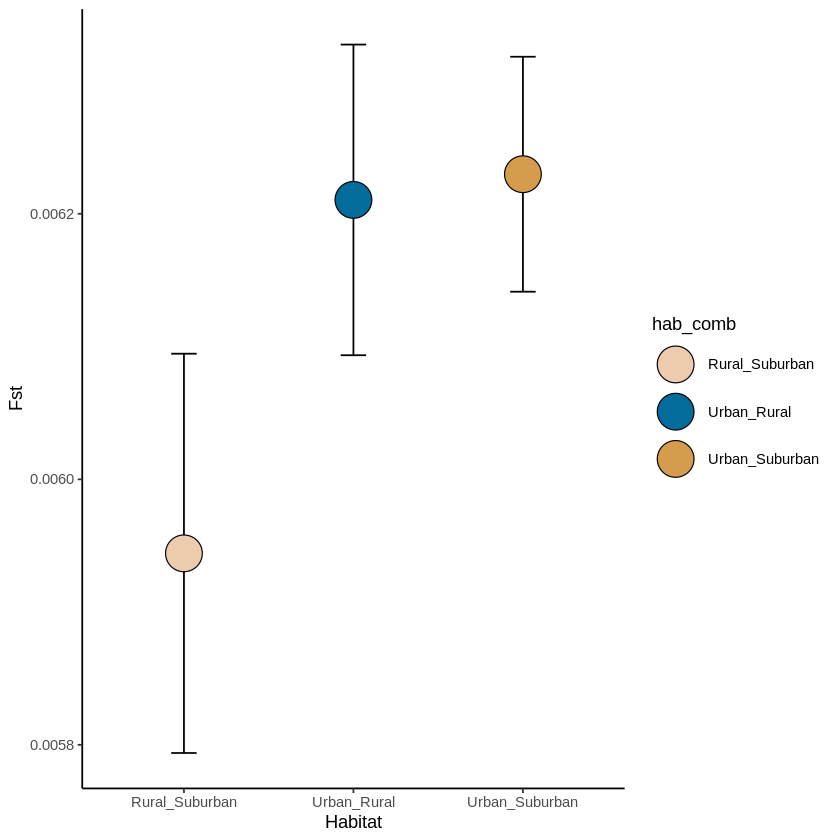

In [59]:
fst_cols <- wes_palette("Darjeeling2", n = 3)
fst_stats %>%
    group_by(hab_comb) %>%
    summarise(mean_fst = mean(fst),
              sd_fst = sd(fst),
              se_fst = sd_fst / sqrt(n())) %>%
    ggplot(., aes(x = hab_comb, y = mean_fst)) +
        geom_errorbar(aes(ymin = mean_fst - se_fst, ymax = mean_fst + se_fst), width = 0.15) +
        geom_point(size = 10, shape = 21, aes(fill = hab_comb)) +
        xlab('Habitat') + ylab("Fst") +
        scale_fill_manual(values = fst_cols) +
#         coord_cartesian(ylim = c(0.02210, 0.0230)) +
        theme_classic()

### Relatedness

- I estimated pairwise relatedness across all samples using genotype likelihoods estimated in `ANGSD`
- Uses same LD-pruned 4fold SNPs as above as for population structure

In [60]:
# Load all chromosomal NGSrelate results and combine into single DF
ngsrelate_output_path <- paste0(results_prefix, 'population_structure/ngsrelate')
relate_df <- list.files(ngsrelate_output_path, pattern = '*.out', full.names = TRUE) %>%
    purrr::map_dfr(., load_relatedness)

In [61]:
# Get order of samples that were used as input to NGSrelate
# Uses all high quality samples (N = 115)
bam_list_path <- paste0(results_prefix, 'program_resources/bam_lists/highQualSamples_4fold_bams.list')
relate_sample_list <- suppressMessages(read_table(bam_list_path, col_names = 'bam')) %>%
    mutate(sample = str_extract(basename(bam), '(s_\\d+_\\d+)(?=_4fold)')) %>%
    separate(sample, into = c('tmp', 'pop', 'ind'), sep = '_', remove = FALSE) %>%
    dplyr::select(-tmp, -bam) %>%
    mutate(idx = seq(from = 0, to = n() - 1))

In [62]:
# Bind sample names to NGSrelate sample IDs
# Add population and habitat info for later comparisons of relatedness among habitats
pops_habitat <- samples %>% 
    rename('pop' = 'Population') %>% 
    dplyr::select(pop, Habitat) %>%
    mutate(pop = as.character(pop)) %>%
    distinct()
relate_df_withHab <- relate_df %>%
    pivot_longer(cols = c('a', 'b'), values_to = 'idx') %>%
    left_join(., relate_sample_list, by = 'idx') %>%
    dplyr::select(-idx) %>%
    left_join(., pops_habitat, by = 'pop') %>%
    pivot_wider(values_from = c('sample', 'pop', 'ind', 'Habitat'))

In [63]:
# Calculate mean relatedness across chromosomes for each sample comparison
mean_relate_acrossChroms <- relate_df_withHab %>%
    group_by(sample_a, sample_b) %>%
    summarise(mean_rab_acrossChroms = mean(rab),
              n = n()) %>%
    left_join(., relate_df_withHab %>%
              dplyr::select(sample_a, sample_b, pop_a, pop_b, Habitat_a, Habitat_b) %>%
              distinct(),
             by = c('sample_a', 'sample_b')) %>%
    ungroup()

`summarise()` has grouped output by 'sample_a'. You can override using the `.groups`
argument.


In [64]:
# Calculate mean relatedness across samples for specific habitat comparisons
mean_relate_acrossHabs <- mean_relate_acrossChroms %>%
    mutate(comparison = case_when(Habitat_a == 'Urban' & Habitat_b == 'Urban' ~ 'Within Urban',
                                  Habitat_a == 'Suburban' & Habitat_b == 'Suburban' ~ 'Within Suburban',
                                  Habitat_a == 'Rural' & Habitat_b == 'Rural' ~ 'Within Rural',
                                  
                                  Habitat_a == 'Urban' & Habitat_b == 'Suburban' ~ 'Urban-Suburban',
                                  Habitat_a == 'Suburban' & Habitat_b == 'Urban' ~ 'Urban-Suburban',
                                  
                                  Habitat_a == 'Urban' & Habitat_b == 'Rural' ~ 'Urban-Rural',
                                  Habitat_a == 'Rural' & Habitat_b == 'Urban' ~ 'Urban-Rural',
                                  
                                  Habitat_a == 'Suburban' & Habitat_b == 'Rural' ~ 'Suburban-Rural',
                                  Habitat_a == 'Rural' & Habitat_b == 'Suburban' ~ 'Suburban-Rural')) %>%
    group_by(comparison) %>%
    summarise(mean_rab = mean(mean_rab_acrossChroms),
              sd_rab = sd(mean_rab_acrossChroms),
              se_rab = sd_rab / sqrt(n()))

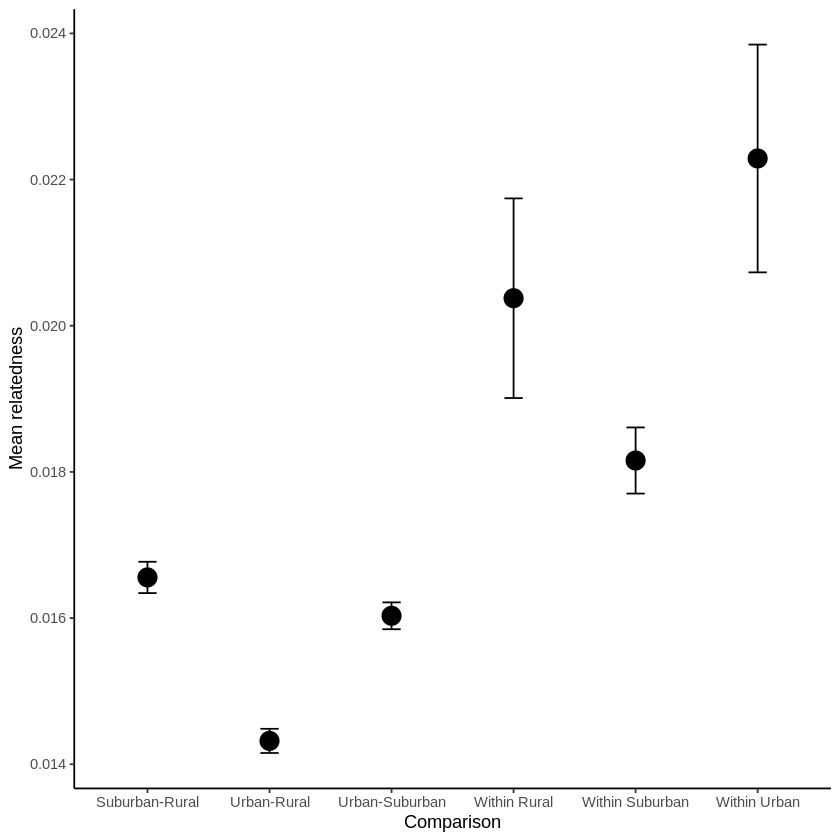

In [65]:
# Plot relatedness comparisons
mean_relate_acrossHabs %>%
    ggplot(., aes(x = comparison, y = mean_rab)) +
    geom_errorbar(aes(ymin = mean_rab - se_rab, ymax = mean_rab + se_rab), width = 0.15) +
    geom_point(size = 5) +
    xlab('Comparison') + ylab('Mean relatedness') +
    scale_fill_manual(values = cols_hab) +
    theme_classic()

In [66]:
mean_relate_acrossChroms %>%
    arrange(desc(mean_rab_acrossChroms)) %>%
    head(n = 10)

sample_a,sample_b,mean_rab_acrossChroms,n,pop_a,pop_b,Habitat_a,Habitat_b
<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
s_97_9,s_97_14,0.7928899,16,97,97,Rural,Rural
s_37_6,s_37_18,0.7919010,16,37,37,Urban,Urban
s_42_3,s_42_9,0.7760183,16,42,42,Urban,Urban
s_83_5,s_83_11,0.7508915,16,83,83,Rural,Rural
s_42_1,s_42_20,0.7404613,16,42,42,Urban,Urban
s_37_11,s_37_18,0.4207409,16,37,37,Urban,Urban
s_37_6,s_37_11,0.4147834,16,37,37,Urban,Urban
s_37_8,s_37_12,0.2821022,16,37,37,Urban,Urban
s_7_6,s_7_13,0.2327082,16,7,7,Rural,Rural


### Population stats

In [69]:
load_population_fst <- function(path){
    pop_a <- str_split(basename(path), '_', simplify = T)[1]
    pop_b <- str_split(basename(path), '_', simplify = T)[2]
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(read_delim(path, delim = '\t', col_names = colnames)) %>%
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
#         group_by(chrom) %>%
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(pop_a = pop_a, pop_b = pop_b)
    return(df)
}

path <- paste0(results_prefix, 'angsd/summary_stats/hudson_fst/byPopulation')
pop_fst_df <- list.files(path, pattern = '*_readable.fst', full.names = T) %>% 
    purrr::map_dfr(., load_population_fst)

In [70]:
pop_fst_df_withHabs <- pop_fst_df %>% 
    left_join(mean_relate_acrossChroms %>% dplyr::select(pop_a, pop_b, Habitat_a, Habitat_b) %>% distinct(),
              by = c('pop_a', 'pop_b'))

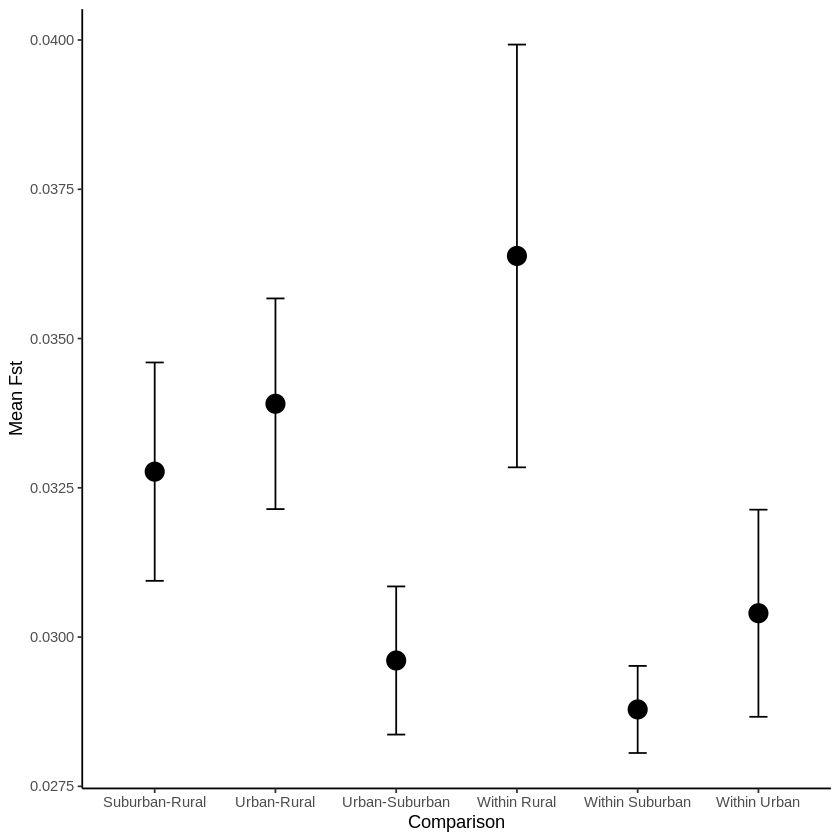

In [71]:
# Calculate mean fst across populations for specific habitat comparisons
mean_fst_acrossHabs <- pop_fst_df_withHabs %>%
    mutate(comparison = case_when(Habitat_a == 'Urban' & Habitat_b == 'Urban' ~ 'Within Urban',
                                  Habitat_a == 'Suburban' & Habitat_b == 'Suburban' ~ 'Within Suburban',
                                  Habitat_a == 'Rural' & Habitat_b == 'Rural' ~ 'Within Rural',
                                  
                                  Habitat_a == 'Urban' & Habitat_b == 'Suburban' ~ 'Urban-Suburban',
                                  Habitat_a == 'Suburban' & Habitat_b == 'Urban' ~ 'Urban-Suburban',
                                  
                                  Habitat_a == 'Urban' & Habitat_b == 'Rural' ~ 'Urban-Rural',
                                  Habitat_a == 'Rural' & Habitat_b == 'Urban' ~ 'Urban-Rural',
                                  
                                  Habitat_a == 'Suburban' & Habitat_b == 'Rural' ~ 'Suburban-Rural',
                                  Habitat_a == 'Rural' & Habitat_b == 'Suburban' ~ 'Suburban-Rural')) %>%
    group_by(comparison) %>%
    summarise(mean_fst = mean(fst),
              sd_fst = sd(fst),
              se_fst = sd_fst / sqrt(n()))

# Plot fst comparisons
mean_fst_acrossHabs %>%
    ggplot(., aes(x = comparison, y = mean_fst)) +
    geom_errorbar(aes(ymin = mean_fst - se_fst, ymax = mean_fst + se_fst), width = 0.15) +
    geom_point(size = 5) +
    xlab('Comparison') + ylab('Mean Fst') +
    scale_fill_manual(values = cols_hab) +
    theme_classic()

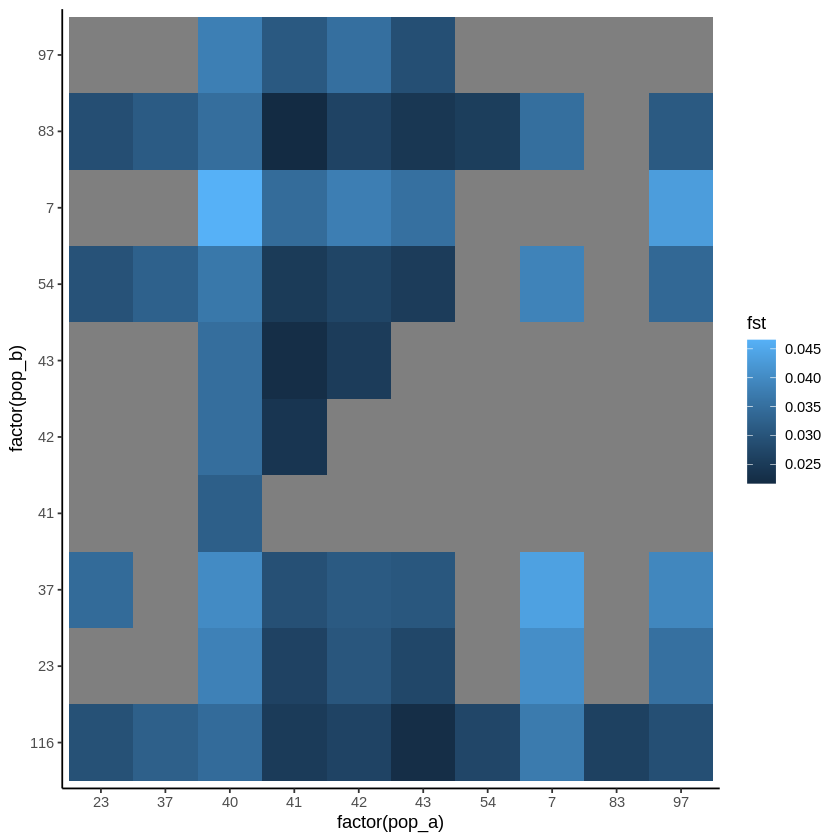

In [72]:
pop_fst_df_withHabs %>%
    complete(pop_a, pop_b) %>% 
    ggplot(., aes(x = factor(pop_a), y = factor(pop_b), fill = fst)) +
    geom_tile() +
    theme_classic()

In [73]:
pop_fst_df_withHabs

num_sum,denom_sum,fst,nSites,pop_a,pop_b,Habitat_a,Habitat_b
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
5674.866,192811.7,0.02943217,10497250,23,116,Suburban,Suburban
6345.854,185295.9,0.03424714,10294143,23,37,Suburban,Urban
5690.049,192238.9,0.02959885,10530755,23,54,Suburban,Suburban
5589.754,193407.2,0.02890147,10523728,23,83,Suburban,Rural
6135.147,190713.1,0.03216950,10419082,37,116,Urban,Suburban
6176.573,190217.2,0.03247116,10451206,37,54,Urban,Suburban
5993.530,191372.3,0.03131869,10445995,37,83,Urban,Rural
6830.641,198901.5,0.03434183,10650471,40,116,Urban,Suburban
7396.554,193349.6,0.03825482,10485793,40,23,Urban,Suburban


In [76]:
# Function to load thetas for a given habitat
load_population_pi <- function(path){
    pop <- str_split(basename(path), '_', simplify = T)[1]
    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites) %>% 
        summarize(pi = mean(tp_scaled)) %>% 
        mutate(pop = pop)
    return(df)
}


path <- paste0(results_prefix, 'angsd/summary_stats/thetas/byPopulation')
pop_pi_df <- list.files(path, pattern = '*.pestPG', full.names = T, recursive = T) %>% 
    purrr::map_dfr(., load_population_pi)

In [77]:
pop_pi_df %>% 
    left_join(samples %>% 
                  dplyr::select(Population, Habitat) %>% 
                  distinct() %>% 
                  mutate(Population = as.character(Population)) %>% 
                  rename('pop' = Population), by = 'pop') 
# %>% 
#     ggplot(., aes(x = pop, y = pi)) +
#         geom_bar(stat = 'identity', color = 'black', fill = 'black') +
#         facet_grid(~Habitat) +
#         theme_classic()

pi,pop,Habitat
<dbl>,<chr>,<chr>
0.01854563,116,Suburban
0.01802873,23,Suburban
0.01755101,37,Urban
0.01815804,40,Urban
0.01863811,41,Urban
0.01796459,42,Urban
0.01857617,43,Urban
0.01839798,54,Suburban
0.01759451,7,Rural


In [107]:
fst.hudson <-function(p1, p2, n1, n2){

    N = (p1 - p2)^2 - p1*(1-p1)/(n1-1) - p2*(1-p2)/(n2-1)
    D = p1*(1-p2) + p2*(1-p1)

    return(N / D)
  }

In [130]:
p1 <- 0.45
p2 <- 0.55
n1 <- 14
n2 <- 14

fst.hudson(p1, p2, n1, n2)

[1] -0.05559787